In [2]:
# For dataset modelling and operations
import pandas as pd
import numpy as np

#For plots generation and dataset analysis
import matplotlib.pyplot as plt

# Built-in library for making clusterings.
import sklearn.cluster as cluster

# ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <b><span style='color:#2322c4'>1| Dataset Loading</span></b>

In [3]:
def read_transpose_data(file):
    '''
    this function will take a .csv file in the world bank format and transpose it into original
    format
    '''
    dataset = pd.read_excel('./climate-change-excel-4-6-mb-.xls', index_col=0)
    dataset = dataset.transpose()
    dataset.columns=dataset.iloc[0]
    dataset = dataset.iloc[:-1]
    dataset = dataset.reset_index()
    dataset = dataset.rename(columns={"index": "Year"})
    
    return dataset

## <b><span style='color:#2322c4'>2| Data Pre-processing</span></b>

In [5]:
def fill_na(df):
    """
    The data is of all countries, it has many null and special values,
    so preprocessing is necessary
    """
    df = df.replace(r'^\..*$', np.NaN, regex=True)
    df.fillna(0, inplace = True)
    return df

def pre_process(df):
    """
    Drop unnecessary columns and filter the Main Indicators we will use for other tasks
    """
    df.drop(columns= ['SCALE', 'Decimals', 'Series code',2011], inplace = True )
    df2 = df.loc[df['Series name'].isin(['CO2 emissions per capita (metric tons)',
                                         'CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)'])] 
    df1 = df.loc[df['Series name'].isin(['CO2 emissions per capita (metric tons)',
                                         'CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)'])] 
    df1['mean'] = df1.median(axis=1)
    df1.drop(columns= [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
                       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010], inplace = True )
    df1 = df1.reset_index()
    return df1, df

## <b><span style='color:#2322c4'>3| Data Transformation</span></b>

In [6]:
def mean_GDP(df):
    """
    Taking the avergae value of GDP throughtout the years of all the countries.
    and Drop those columns after filtering the columns.
    """
    df['mean_gdp'] = df['mean'].iloc[233:466]
    df['mean_gdp'].iloc[0:233] = df['mean'].iloc[233:466]
    df = df.drop(df.index[233:], axis=0)
    df.drop(columns= ['Country code', 'Series name'], inplace = True )
    df1 = df.drop([df.index[175],df.index[206],df.index[219]], axis=0)
    return df1

## <b><span style='color:#2322c4'>4| Dataset Normalization</span></b>

In [8]:
def norm(array):
    """ 
    Returns array normalised to [0,1]. 
    Array can be a numpy array or a column of a dataframe
    """
    min_val = np.min(array)
    max_val = np.max(array)
    scaled = (array-min_val) / (max_val-min_val)
    return scaled

def norm_df(df):
    """
    Returns all columns of the dataframe normalised to [0,1] with the
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine.
    """
    # iterate over all columns
    for col in df.columns[1:]: # excluding the first column
            df[col] = norm(df[col])
    return df

## <b><span style='color:#2322c4'>5| Plots charts and Dataset</span></b>

In [17]:
def makeplot(df, col1, col2):
    """
    Produces a square plot of two columns of dataframe df using small circle symbols.
    """
    plt.plot(df1[col1], df1[col2], "o", markersize=3)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

## <b><span style='color:#2322c4'>Explore Public Data from the world bank </span></b>

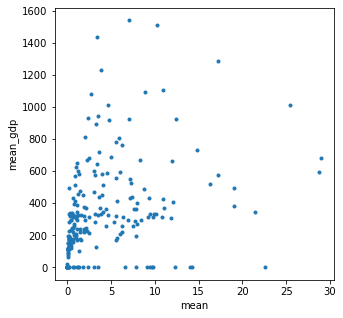

In [18]:
df = read_transpose_data()                     # Read dataset file
df = fill_na(df)                     # Remove null values
df1, df2 = pre_process(df)           # Preprocess the dataset
df1 = mean_GDP(df1)                  # Dataset averaging

plt.figure(figsize=(5, 5))
makeplot(df1, "mean", "mean_gdp")    # explortory data analysis

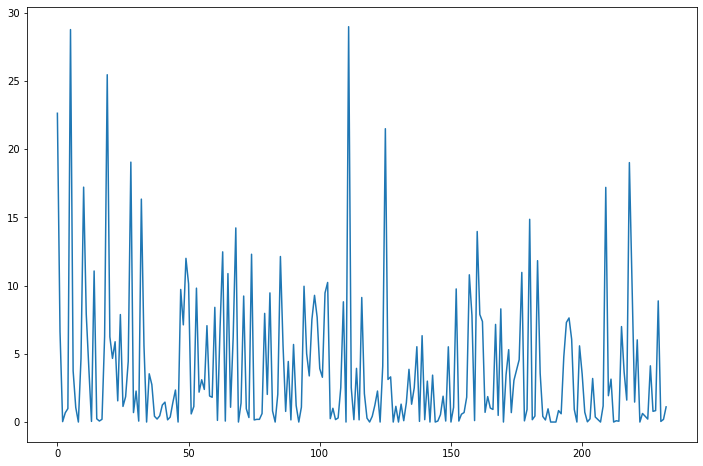

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(df1['mean'])       # GDP values

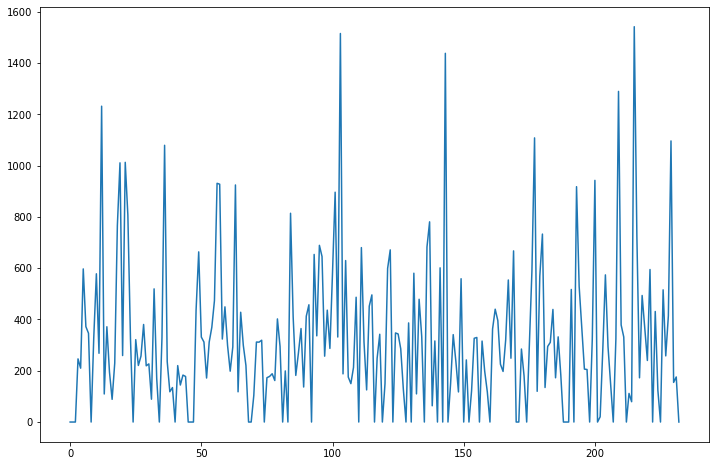

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(df1.mean_gdp)    # GDP mean values 

## <b><span style='color:#2322c4'>Visualize the Normalized Data.</span></b>

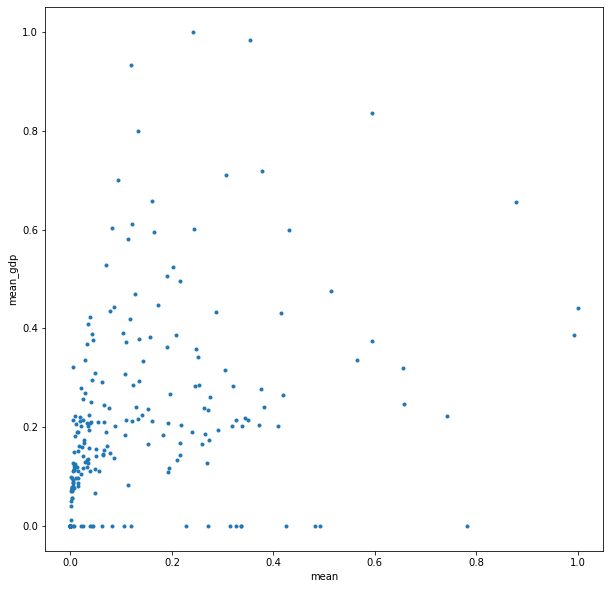

In [27]:
df_norm = norm_df(df1)
plt.figure(figsize=(10, 10))
makeplot(df_norm, "mean", "mean_gdp")

## <b><span style='color:#2322c4'> | Missing Values.</span></b>

<function matplotlib.pyplot.show(close=None, block=None)>

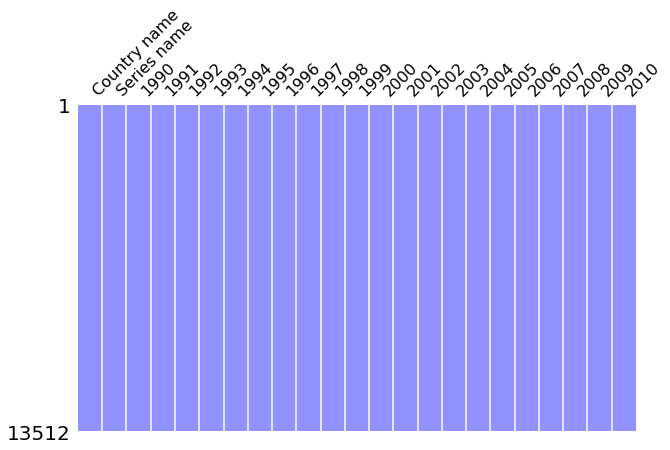

In [42]:
"""
Lets see the missing values first and then fix those outliers. This time I am using a library names "missingno",
It will show the missing values in a viusal effects. We will then analyze the missing values
in each features and then try to fix those.
"""
import missingno as ms

fig, ax = plt.subplots(figsize=(10,6))
ms.matrix(df, ax=ax, sparkline=False, color=(0.57, 0.57, 1.0))
plt.show

# No null/missing values

# <b><span style='color:#2322c4'> | K-means Clustering</span></b>

In [77]:
####### kmeans set up the clusterer, 3 expected clusters
kmeans = cluster.KMeans(n_clusters=3)

# extract columns for fitting
df_fit = df1[["mean", "mean_gdp"]].copy()
kmeans.fit(df_fit)

# extract labels and cluster centres
labels = kmeans.labels_
cen = kmeans.cluster_centers_

## <b><span style='color:#2322c4'> | Visualize Clustering results</span></b>

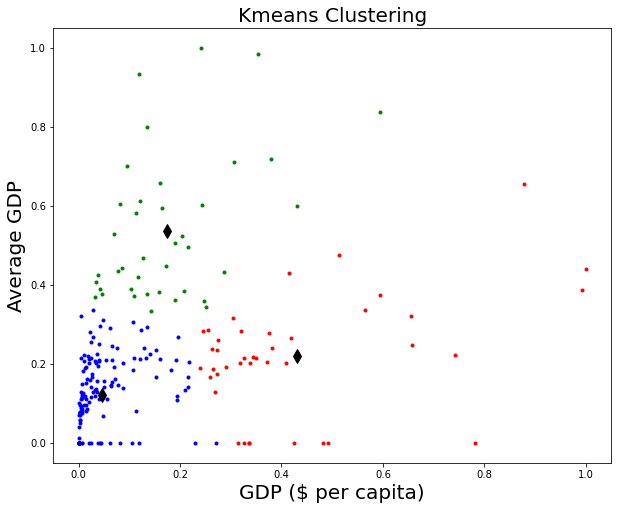

In [86]:
# plot using the labels to select colour
plt.figure(figsize=(10, 8))
col = ["blue", "red", "green", "magenta"]
for l in range(3): # loop over the different labels 
    plt.plot(df_fit["mean"][labels==l], df_fit["mean_gdp"][labels==l], "o",
             markersize=3, color=col[l])

# show cluster centres
for ic in range(3):
    xc, yc = cen[ic,:]
    plt.plot(xc, yc, "dk", markersize=10)

plt.title("Kmeans Clustering", fontsize = 20)
plt.xlabel("GDP ($ per capita)", fontsize = 20)
plt.ylabel("Average GDP", fontsize = 20)
plt.show()

# <b><span style='color:#2322c4'> | Agglomerative Clustering.</span></b>

In [49]:
##### setting up agglomerative clustering for 6 clusters
ac = cluster.AgglomerativeClustering(n_clusters=3)

# carry out the fitting
df_fit = df1[[ "mean", "mean_gdp"]].copy()
ac.fit(df_fit)

labels = ac.labels_

# The clusterer does not return cluster centres, but they are easily computed
xcen = []
ycen = []
for ic in range(3):
    xc = np.average(df_fit["mean"][labels==ic])
    yc = np.average(df_fit["mean_gdp"][labels==ic])
    xcen.append(xc)
    ycen.append(yc)

## <b><span style='color:#2322c4'> | Visualize Clustering results</span></b>

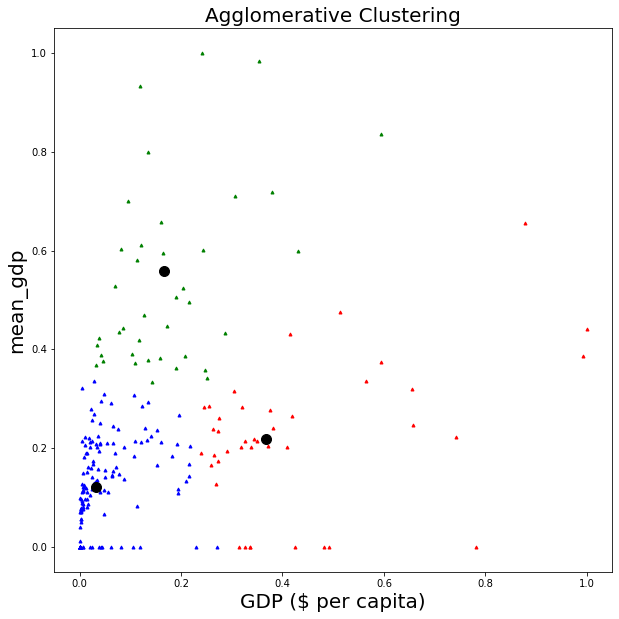

In [107]:
# plot using the labels to select colour
plt.figure(figsize=(10,10))

col = ["blue", "red", "green", "magenta","yellow","aqua"]
for l in range(0,3):     # loop over the different labels
    plt.plot(df_fit["mean"][labels==l], df_fit["mean_gdp"][labels==l],
             "^", markersize=3, color=col[l])
    
# show cluster centres
for ic in range(3):
    plt.plot(xcen[ic], ycen[ic], ".", markersize=20, color = "k")

plt.title("Agglomerative Clustering", fontsize = 20)     
plt.xlabel("GDP ($ per capita)", fontsize = 20)
plt.ylabel("mean_gdp", fontsize = 20)
plt.show()


###### writing labels into df_fish, sorting and exporting as excel file
df1["labels"] = labels
df1 = df1.sort_values(["labels"], ignore_index=True)

## <b><span style='color:#2322c4'> | Data Fitting (curve_fit)</span></b>

In [88]:
df1['label'] = kmeans.labels_

In [89]:
df1

,Country name,mean,mean_gdp,labels,label
0,Aruba,0.780996,0.000000,0,1
1,Kazakhstan,0.353020,0.982772,0,2
2,Belarus,0.203097,0.523434,0,2
3,Slovak Republic,0.251912,0.343173,0,2
4,Ecuador,0.065878,0.209874,0,0
...,...,...,...,...,...
225,Saudi Arabia,0.512788,0.475433,2,1
226,Nepal,0.003660,0.076046,2,0
227,"Congo, Dem. Rep.",0.001556,0.100234,2,0
228,Zambia,0.006712,0.114005,2,0


In [104]:
data = pd.read_csv("./WDI_country.csv")

In [105]:
"""
Define the logistics functions for fitting.
"""
  
def logistics(t, scale, growth, t0):
    """ Computes logistics function with scale, growth raat
    and time of the turning point as free parameters
    """
    
    f = scale / (1.0 + np.exp(-growth * (t - t0)))
    return f    

Fit parameter [2.52480676e+09 2.96170675e-02 2.01171142e+03]


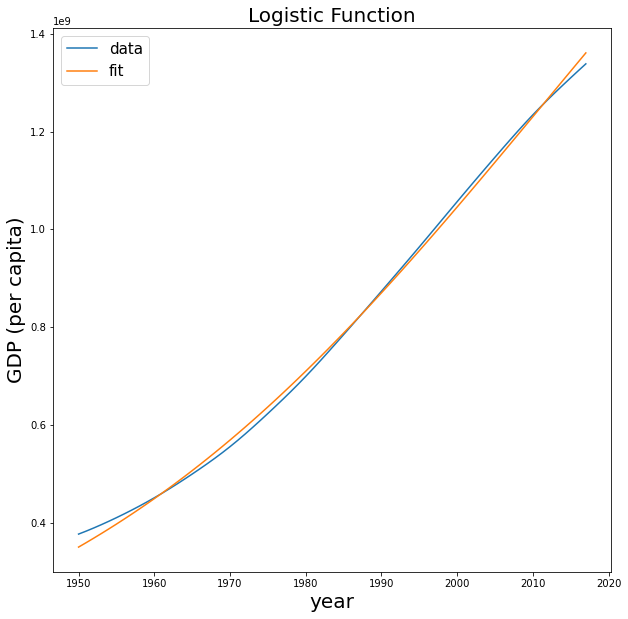

In [129]:
"""
fit the logistics function with some initial parameters such as p0. It will give us much better results 
fit logistic growth and then calculate/ plot the result. 
"""

# fit exponential growth
p, c = opt.curve_fit(logistics, data["year"], data["GDP"], p0=(2e9, 0.05, 1990.0))
# much better
print("Fit parameter", p)

data["logistic"] = logistics(data["year"], *p)

plt.figure(figsize=(10,10))
plt.plot(data["year"], data["GDP"], label="data")
plt.plot(data["year"], data["logistic"], label="fit")

plt.legend(fontsize = 15)
plt.xlabel("year", fontsize = 20)
plt.ylabel("GDP (per capita)", fontsize = 20)
plt.title("Logistic Function", fontsize = 20)
plt.show()
print()


# <b><span style='color:#2322c4'> | Error Ranges (err_range)</span></b>

In [61]:
!pip install lmfit

In [109]:
from numpy import exp, loadtxt, pi, sqrt
import itertools as iter
import scipy.optimize as opt

from lmfit import Model
from sklearn.linear_model import LinearRegression

In [111]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

[9.44349836e+07 6.01576537e-04 2.44923945e+00]


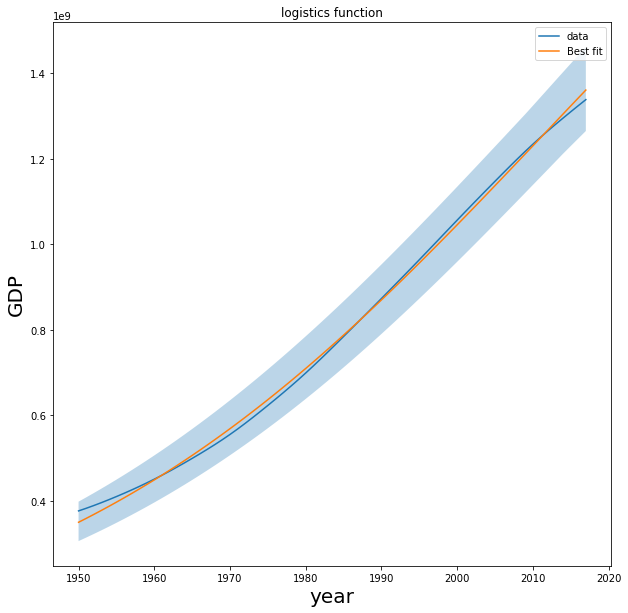

In [121]:
# extract the sigmas from the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(c))
print(sigma)

low, up = err_ranges(data["year"], logistics, p, sigma)

plt.figure(figsize=(10,10))
plt.title("logistics function")
plt.plot(data["year"], data["GDP"], label="data")
plt.plot(data["year"], data["logistic"], label="Best fit")

plt.fill_between(data["year"], low, up, alpha=0.3)
plt.legend()
plt.xlabel("year", fontsize = 20)
plt.ylabel("GDP per capita", fontsize = 20)
plt.show()


In [119]:
# Give Ranges

print("Forcasted GDP")
low, up = err_ranges(2030, logistics, p, sigma)
print("2030 between ", low, "and", up)
low, up = err_ranges(2040, logistics, p, sigma)
print("2040 between ", low, "and", up)
low, up = err_ranges(2050, logistics, p, sigma)
print("2050 between ", low, "and", up)

Forcasted GDP
2030 between  1489613748.4262006 and 1707048163.5899236
2040 between  1650519621.8621323 and 1877585012.4929025
2050 between  1795631427.8485541 and 2027295272.1060772
